In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras import optimizers
from keras.models import Sequential, save_model
from keras.layers import Dense, Dropout, BatchNormalization, Activation
%matplotlib inline

Using TensorFlow backend.


In [2]:
def myGenerator():
    #loading data
    dataset = np.loadtxt('../data/higgs_small.txt',delimiter=',', skiprows=1)

    np.random.shuffle(dataset)

    X = dataset[:, 0:28]
    Y = dataset[:, 28]

    # split data into train and test sets
    seed = 7
    test_size = 0.2
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_size, random_state=seed)

    

    scaler1st = StandardScaler()
    scaler1st.fit(X_train)
    X_train = scaler1st.transform(X_train)
    X_test = scaler1st.transform(X_test)
    
    
    batches = 64
    while 1:
        for i in range(78):
            yield X_train[i*batches:(i+1)*batches], y_train[i*batches:(i+1)*batches]

In [3]:
dataset = np.loadtxt('../data/higgs_small.txt',delimiter=',', skiprows=1)

np.random.seed(42)
np.random.shuffle(dataset)

X = dataset[:, 0:28]
Y = dataset[:, 28]

# scaler1st = StandardScaler()
# X = scaler1st.fit_transform(X)

# split data into train and test sets
seed = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=test_size, random_state=seed)

scaler1st = StandardScaler()
scaler1st.fit(X_train)
X_train = scaler1st.transform(X_train)
X_test = scaler1st.transform(X_test)

In [5]:
def DNN(X, y, batch_size=64, epochs=5, nodes=100, hidden_layers=2):
    # Generate model
    model = Sequential()
    # Input layer
    model.add(Dense(100, input_shape=(X.shape[1],), kernel_initializer='he_normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    # Hidden layers
    for i in range(hidden_layers):
        model.add(Dense(nodes, kernel_initializer='he_normal', activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
    
    model.add(Dense(1, activation='sigmoid'))
    # Set loss and optimizer
    opt =  optimizers.Adam(decay=0.0001,amsgrad=True)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt, metrics=['accuracy', ])

    # Store model to file
    # model.save('model.h5')
    # model.summary()
    model.fit(X, y, epochs=epochs, batch_size=64,
                        validation_split=0.25, verbose=1)
    # my_generator = myGenerator()
    # history = model.fit_generator(my_generator, epochs=5,steps_per_epoch=10000, verbose=1)

    
    return model


In [6]:
# train_predict = model.predict_proba(X_train)
# test_predict = model.predict_proba(X_test)
# # y_test = y_test.reshape(y_test.shape[0], 1)
# # predict = predict.reshape(predict.shape[0], 1)
# fpr, tpr, thresholds = roc_curve(y_test, test_predict)
# auc_n = auc(fpr, tpr)

In [7]:
my_model = DNN(X=X_train, y=y_train,epochs=10, batch_size=64)
print(my_model.summary())
train_predict = my_model.predict_proba(X_train)
test_predict = my_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, test_predict)
auc_n = auc(fpr, tpr)

Train on 5999 samples, validate on 2000 samples
Epoch 1/10
5999/5999 [==============================] - 3s 566us/step - loss: 0.7929 - acc: 0.5328 - val_loss: 0.6711 - val_acc: 0.6040
Epoch 2/10
5999/5999 [==============================] - 1s 209us/step - loss: 0.7119 - acc: 0.5674 - val_loss: 0.6544 - val_acc: 0.6170
Epoch 3/10
5999/5999 [==============================] - 1s 197us/step - loss: 0.6807 - acc: 0.5993 - val_loss: 0.6508 - val_acc: 0.6210
Epoch 4/10
5999/5999 [==============================] - 1s 186us/step - loss: 0.6712 - acc: 0.6061 - val_loss: 0.6450 - val_acc: 0.6290
Epoch 5/10
5999/5999 [==============================] - 2s 251us/step - loss: 0.6584 - acc: 0.6113 - val_loss: 0.6385 - val_acc: 0.6330
Epoch 6/10
5999/5999 [==============================] - 1s 198us/step - loss: 0.6420 - acc: 0.6341 - val_loss: 0.6372 - val_acc: 0.6380
Epoch 7/10
5999/5999 [==============================] - 1s 209us/step - loss: 0.6291 - acc: 0.6431 - val_loss: 0.6332 - val_acc: 0.6435


In [8]:
print(auc_n)

0.7136397602748313


0.98639655
(2000, 1)


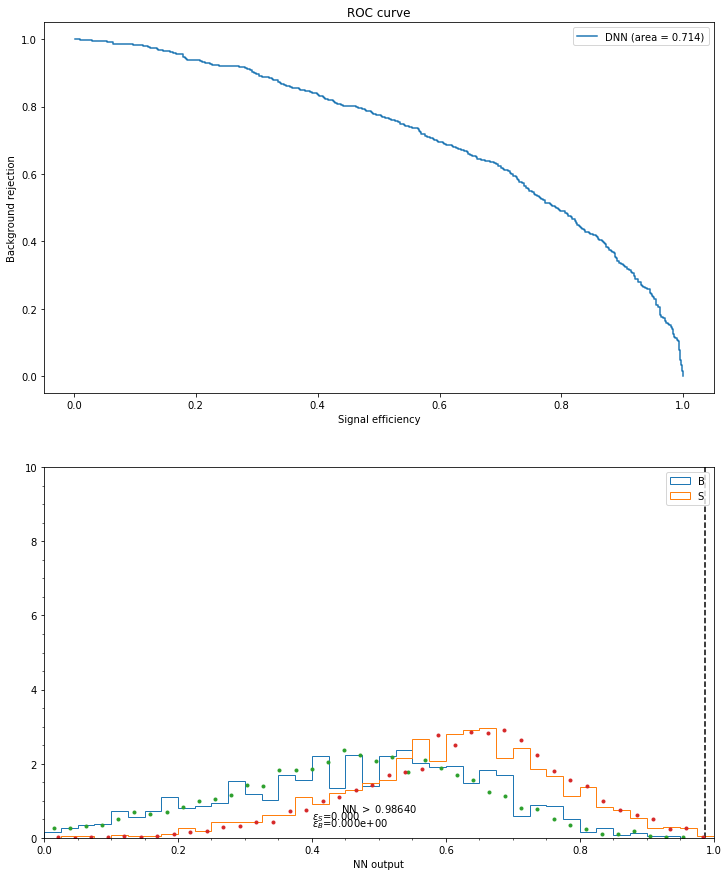

In [9]:
FullThresholdSet = thresholds[np.argmin(abs(fpr-7e-5))]
print(FullThresholdSet)


plt.figure(figsize=(12, 15))
plt.subplot(2, 1, 1)
plt.plot(tpr, (1 - fpr), label='DNN (area = {:.3f})'.format(auc_n))
plt.legend(loc='lower right', frameon=False, fontsize=12)
plt.xlabel('Signal efficiency')
plt.ylabel('Background rejection')
plt.title('ROC curve')
plt.legend(loc='best')
# plt.xscale('log')
# plt.ylim(1e-6,1)

plt.subplot(2, 1, 2)
plt.hist(test_predict[y_test == 0], bins=40, range=(
    0, 1), normed=True, histtype='step', label='B')
plt.hist(test_predict[y_test == 1], bins=40, range=(
    0, 1), normed=True, histtype='step', label='S')
# plt.yscale('log')
plt.legend(loc='best')
plt.xlim(0, 1)
plt.ylim(1e-3, 1e1)
plt.vlines(FullThresholdSet, 1e-3, 1e3, linestyle='--')
plt.xlabel('NN output')

print(test_predict.shape)
plt.text(0.5, 0.7, r"NN $>$ {0:.5f}".format(FullThresholdSet), ha='center')
plt.text(0.4, 0.50, r'$\epsilon_{S}$'+'={0:.3f}'.format(float(sum(
    test_predict[y_test == 1] > FullThresholdSet)[0])/sum(y_test == 1)), ha='left')
plt.text(0.4, 0.3, r'$\epsilon_{B}$'+'={0:.3e}'.format(float(sum(
    test_predict[y_test == 0] > FullThresholdSet)[0])/sum(y_test == 0)), ha='left')

countsS, bin_edgesS = np.histogram(
    train_predict[y_train == 0], 40, density=True)
bin_centresS = (bin_edgesS[:-1] + bin_edgesS[1:])/2.
# errS = np.sqrt(countsS)
plt.errorbar(bin_centresS, countsS, fmt='.')

countsB, bin_edgesB = np.histogram(
    train_predict[y_train == 1], 40, density=True)
bin_centresB = (bin_edgesB[:-1] + bin_edgesB[1:])/2.
# errB = np.sqrt(countsB)
plt.errorbar(bin_centresB, countsB, fmt='.')
plt.minorticks_on()
plt.show()

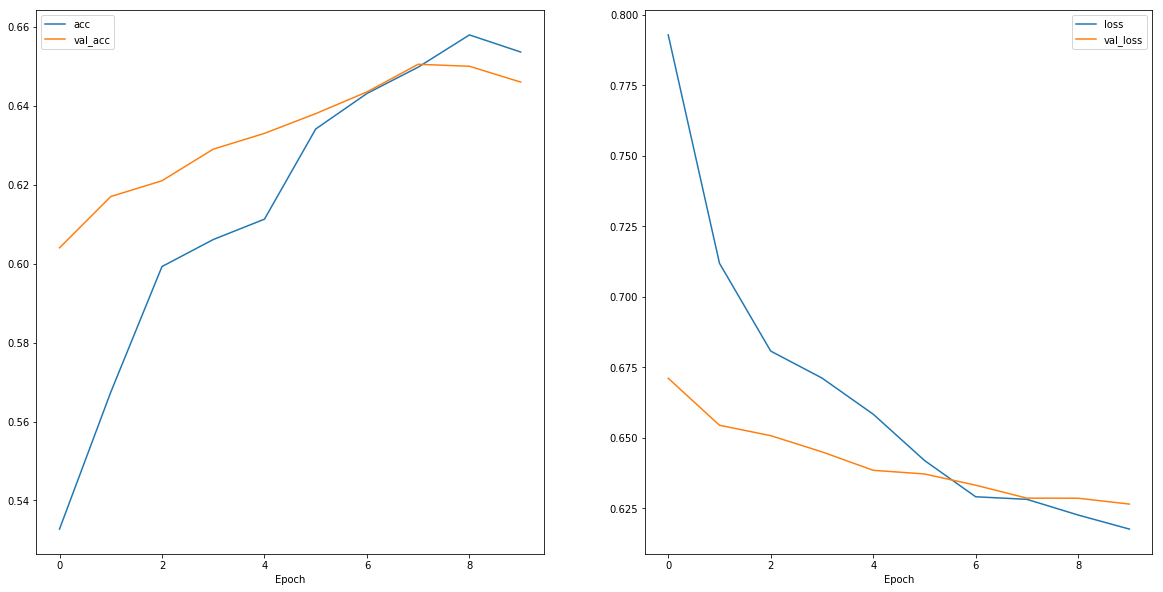

In [10]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(my_model.history.history['acc'],label='acc')
plt.plot(my_model.history.history['val_acc'],label='val_acc')
plt.legend()
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(my_model.history.history['loss'],label='loss')
plt.plot(my_model.history.history['val_loss'],label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.show()